# Fake News Detection

Data from Kaggle
https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.style.use('ggplot')
import seaborn as sns

import regex as re
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn.svm import SVC

from sklearn import metrics
from sklearn import cluster
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
#Read csv files
fake = pd.read_csv('fake.csv')
true = pd.read_csv('true.csv')

EDA

In [3]:
#Examining the data from each file
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake.shape

(23481, 4)

In [5]:
fake.dtypes

title      object
text       object
subject    object
date       object
dtype: object

In [6]:
fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [7]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
true.shape

(21417, 4)

In [9]:
true.dtypes

title      object
text       object
subject    object
date       object
dtype: object

In [10]:
true['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [11]:
#Adding a column to each dataframe for if the news is true or not
fake['true'] = 0
true['true'] = 1

In [12]:
#Combining the two dataframes into one
df = pd.concat([fake, true], ignore_index=True)
df.shape

(44898, 5)

In [13]:
#Since the full number of rows takes a long time to run the following, using sample to take a smaller number of rows
news = df.sample(n=1000, random_state=42)

In [14]:
#Checking for any null values
news.isnull().sum()

title      0
text       0
subject    0
date       0
true       0
dtype: int64

Cleaning text for models

In [15]:
#load spaCy and the English model
nlp = spacy.load('en_core_web_sm')

In [16]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [17]:
news['title'] = news['title'].apply(clean_text)
news['text'] = news['text'].apply(clean_text)
news

,title,text,subject,date,true
22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
27917,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
25007,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
32476,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1
...,...,...,...,...,...
27000,Path cleared for Congress to consider U.S. arm...,WASHINGTON (Reuters) - U.S. Secretary of State...,politicsNews,"May 30, 2017",1
25165,Democrats urge full review before Senate vote ...,WASHINGTON (Reuters) - Democratic leaders in t...,politicsNews,"September 18, 2017",1
20813,WHY PICTURE OF CHE-OBAMA Was Much Worse Than A...,"Oh the irony, of our Nobel-Peace-Prize-Recipie...",left-news,"Mar 25, 2016",0
11756,#Berkeley CRAZY! RIOTERS CHASE And Beat People...,Is anyone else thinking what we re thinking ab...,politics,"Feb 2, 2017",0


In [18]:
#Removing stop words, punctuation, digits, and lemmatization
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())     
        text = ' '.join(tokens)

    return text

In [19]:
%%time
news['shorttitle'] = news['title'].apply(convert_text)
news['short'] = news['text'].apply(convert_text)

Wall time: 1min 3s


In [20]:
news.head()

,title,text,subject,date,true,shorttitle,short
22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,ben stein call 9th circuit court commit coup d...,21st century wire say ben Stein reputable prof...
27917,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,trump drop steve bannon national security council,WASHINGTON Reuters U.S. president donald Trump...
25007,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,puerto rico expect U.S. lift jones act shippin...,Reuters puerto rico governor ricardo rossello ...
1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,OOPS trump accidentally confirm leaked Israe...,Monday donald Trump embarrass country accident...
32476,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,donald trump head Scotland reopen golf resort,GLASGOW Scotland Reuters U.S. presidential can...


Models

In [21]:
# Features and Labels using 'short' column for X
target_col = 'true'
feature_cols = 'short'

X =  news[feature_cols]
y = news[target_col]

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
#Bag of Words
# create a matrix of word counts from the text
counts = CountVectorizer()

# do the actual counting
A = counts.fit_transform(X_train, y_train)

# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

# do the transformation for the test data`
B = counts.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B.toarray())

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions, average='weighted')
recall = metrics.recall_score(y_test, predictions, average='weighted')
f1 = metrics.f1_score(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.95
Precision: 0.9506632499246308
Recall: 0.95
F1 Score: 0.9499498746867167


In [23]:
#TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B.toarray())

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions, average='weighted')
recall = metrics.recall_score(y_test, predictions, average='weighted')
f1 = metrics.f1_score(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.94
Precision: 0.9402120212021202
Recall: 0.94
F1 Score: 0.9400120048019207


In [24]:
#Naive Bayes with CountVectorizer, used ChatGPT
# Convert text data to a bag-of-words representation
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Create and train the Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions, average='weighted')
recall = metrics.recall_score(y_test, predictions, average='weighted')
f1 = metrics.f1_score(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.905
Precision: 0.9050120192307693
Recall: 0.905
F1 Score: 0.9049833546093967


In [25]:
#Naive Bayes with TF-IDF as the vectorizer
# Convert text data to a bag-of-words representation
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Create and train the Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions, average='weighted')
recall = metrics.recall_score(y_test, predictions, average='weighted')
f1 = metrics.f1_score(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.895
Precision: 0.895008012820513
Recall: 0.895
F1 Score: 0.8949816024630173


In [26]:
# helper function to show results and charts
def show_summary_report(actual, prediction, probabilities):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, probabilities)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, probabilities)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

*********
* Count *
*********
Accuracy : 0.9500 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9346 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9709 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9883                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


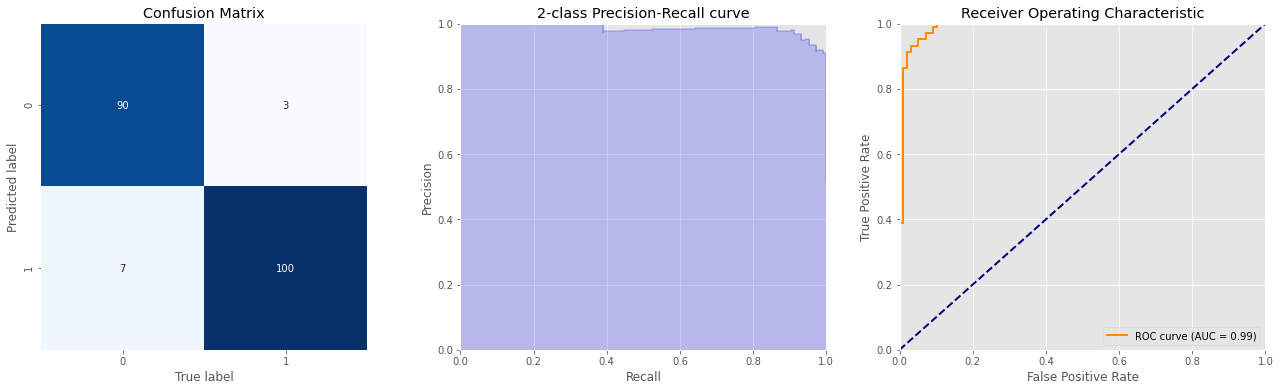

**********
* TF-IDF *
**********
Accuracy : 0.9400 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9505 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9320 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9828                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


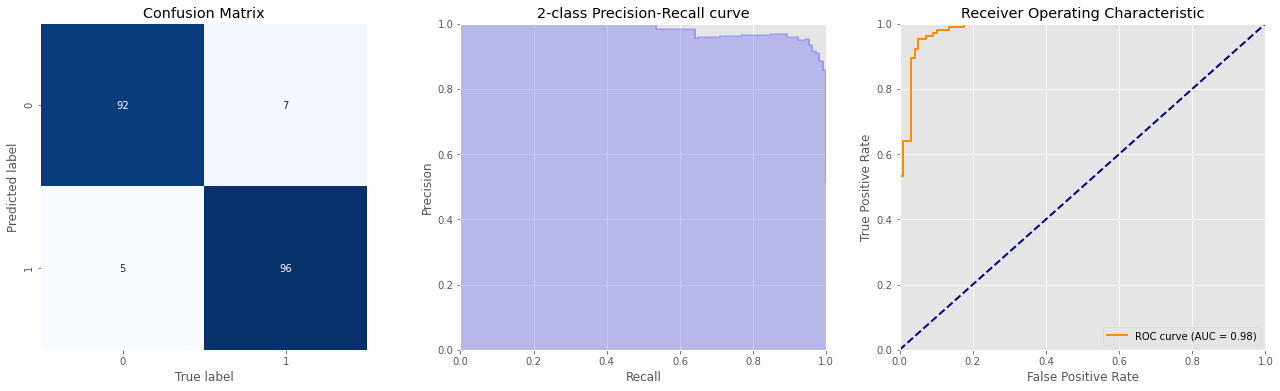

In [27]:
#Comparing Bag of Words and TF-IDF
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDF']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))

    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_train, y_train)

    # create a classifier using SVC
    classifier = SVC(kernel='linear', probability=True)

    # train the classifier with the training data
    classifier.fit(A.toarray(), y_train)
    
    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_test)

    # make predictions based on the test data
    predictions = classifier.predict(B.toarray())

    # store probabilities of predictions being 1
    probabilities = classifier.predict_proba(B.toarray())[:, 1]

    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}

In [28]:
# Features and Labels using 'shorttitle' column for X
target_col = 'true'
feature_cols = 'shorttitle'

X =  news[feature_cols]
y = news[target_col]

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

*********
* Count *
*********
Accuracy : 0.8650 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8115 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9612 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9514                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


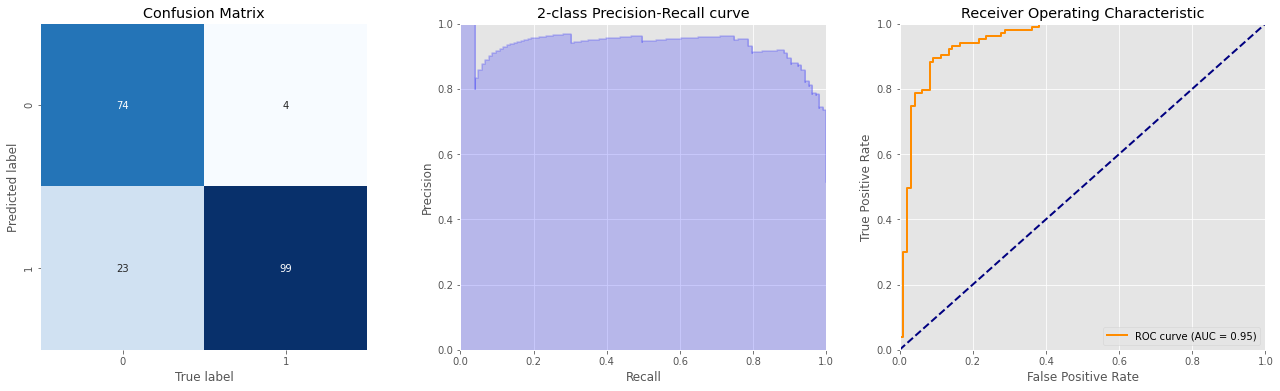

**********
* TF-IDF *
**********
Accuracy : 0.8900 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8932 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8932 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9554                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


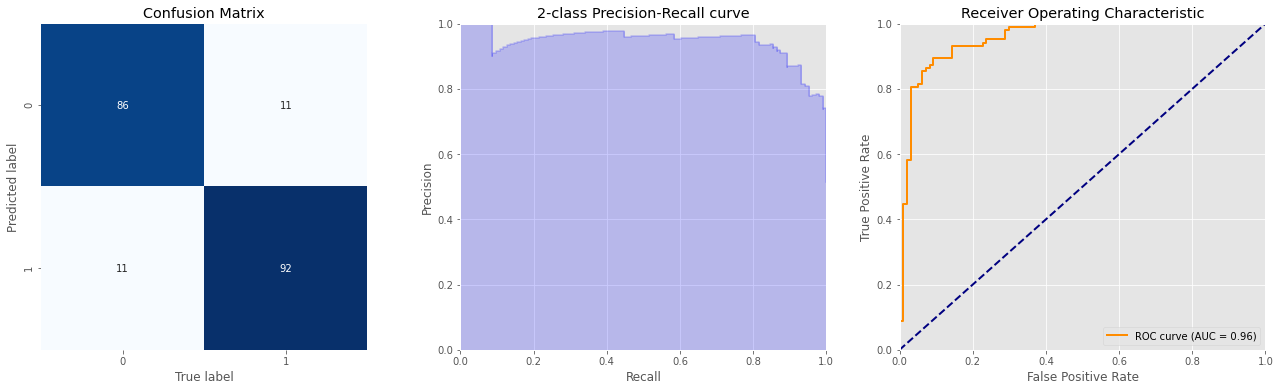

In [29]:
#Comparing Bag of Words and TF-IDF
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDF']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))

    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_train, y_train)

    # create a classifier using SVC
    classifier = SVC(kernel='linear', probability=True)

    # train the classifier with the training data
    classifier.fit(A.toarray(), y_train)
    
    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_test)

    # make predictions based on the test data
    predictions = classifier.predict(B.toarray())

    # store probabilities of predictions being 1
    probabilities = classifier.predict_proba(B.toarray())[:, 1]

    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}

Overall, CountVectorizer without Naive Bayes and with 'short' as the feature column has the highest accuracy.